# Benchmark Tabular Causal Discovery Algorithms

The benchmarking module for continuous data is **BenchmarkContinuousTabular** and for discrete data is **BenchmarkDiscreteTabular**. We import them as follows:

In [1]:
from causalai.benchmark.tabular.continuous import BenchmarkContinuousTabular
from causalai.benchmark.tabular.discrete import BenchmarkDiscreteTabular

Bechmarking modules allow benchmarking causal discovery algorithms on synthetically generated data across various aspects. For tabular data, the supported methods for the aforementioned modules:

1. **benchmark_variable_complexity**: variable complexity (BenchmarkDiscreteTabular and BenchmarkContinuousTabular)
2. **benchmark_sample_complexity**: sample complexity (BenchmarkDiscreteTabular and BenchmarkContinuousTabular)
3. **benchmark_graph_density**: graph density (BenchmarkDiscreteTabular and BenchmarkContinuousTabular)
4. **benchmark_noise_type**: noise type (BenchmarkContinuousTabular)
5. **benchmark_snr**: signal to noise ratio (BenchmarkContinuousTabular)

In addition to bechmarking on synthetic data, we also support benchmarking algorithms on user provided data. This is discussed in more detail under the section **Custom Data**.

The main purpose of synthetic data benchmarking is to evaluate two aspects:

1. how a specific caual discovery algorithm performs for different values of a variant (the above listed aspects).
2. how different algorithms compare against each other in a particular setting.



### How to specify causal discovery algorithms?

Specifying causal discovery algorithms supported by the CausalAI library is very easy as shown below. Users also have the option to specify a custom algorithm as long as it adheres to the basic requirements. This is discussed on more detail under the section **Custom Algorithms**.

Let's begin with a simple example, in which we want to benchmark causal discovery algorithms on synthetically generated discrete data.

We begin by importing the supported algorithms for discrete data:

In [2]:
from causalai.models.tabular.pc import PC
from causalai.models.common.CI_tests.partial_correlation import PartialCorrelation
from causalai.models.common.CI_tests.discrete_ci_tests import DiscreteCI_tests

from causalai.models.tabular.ges import GES
from causalai.models.tabular.lingam import LINGAM

from functools import partial
import numpy as np

Next, we create a Python dictionary of these algorithms in a format that the benchmarking module requires. Then we run the benchmarking module for sample complexity.

In [3]:
algo_dict = {
        'PC-Pearson':partial(PC, CI_test=DiscreteCI_tests(method="pearson"), use_multiprocessing=False,
                                  prior_knowledge=None),
        'PC-Log-Likelihood':partial(PC, CI_test=DiscreteCI_tests(method="log-likelihood"), use_multiprocessing=False,
                                  prior_knowledge=None),}

kargs_dict = {
        'PC-Pearson': {'max_condition_set_size': 4, 'pvalue_thres': 0.01},
        'PC-Log-Likelihood': {'max_condition_set_size': 4, 'pvalue_thres': 0.01},}

**algo_dict** specifies the algorithms. Specifically, keys are the names of the algorithms, and values are the algorithm class. We use partial in order to pre-specify some arguments of the algorithm class constructor-- CI_test, use_multiprocessing, and prior_knowledge in the above cases.

All these algorithms have a .run() method that performs the causal discovery. The benchmarking module internally calls this run method. This run method may have some arguments of its own. These arguments are pre-specified using **kargs_dict** above, and passed to the benchmarking module below. Of course, the kargs_dict is algorithm specific, and may be optional.

**Default algo_dict and kargs_dict**: If algo_dict and kargs_dict are not specified (pass None for both), then there are default algo_dict and kargs_dict, that are used by the benchmarking modules, which include all the currently supported algorithms. The default algo_dict and kargs_dict for the BenchmarkDiscreteTabular module can be accessed through:

BenchmarkDiscreteTabular.default_algo_dict and BenchmarkDiscreteTabular.default_kargs_dict

Similarly, the default algo_dict and kargs_dict for the BenchmarkContinuousTabular module can be accessed through:

BenchmarkContinuousTabular.default_algo_dict and BenchmarkContinuousTabular.default_kargs_dict

We run the benchmark_sample_complexity method of the module below,

In [4]:
b = BenchmarkDiscreteTabular(algo_dict=algo_dict, kargs_dict=kargs_dict, 
                             num_exp=10, custom_metric_dict=None)
b.benchmark_sample_complexity(T_list=[100, 500,1000,5000], num_vars=20, graph_density=0.1,\
                           fn = lambda x:x, coef=0.1, noise_fn=np.random.randn) # default arguments in the library
# note that the first argument for all the benchmarking methods is always the list of values of the variant

100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:24<00:00,  2.46s/it]


Here, in addition to algo_dict and kargs_dict, we have passed two additional arguments-- num_exp and custom_metric_dict to the benchmarking module constructer. 

num_exp specifies the number of experiments (each with a different random seed) to run per configuration. 

custom_metric_dict can be used to specify any metric to record in addition to the default metrics that are recorded for the experiments conducted-- f1_score, precision, recall, and time_taken. We provide more detail about this below under the section **custom_metric_dict**.

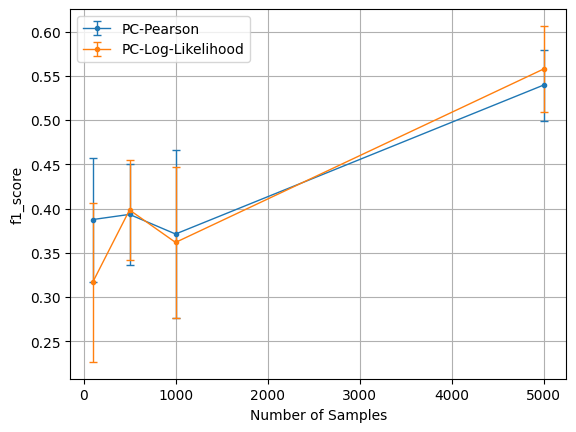

In [5]:
plt=b.plot('f1_score', xaxis_mode=1)
# plt.savefig('myfig.pdf')
plt.show()

### Useful Methods and Attributes

The benchmarking modules have the following attributes that users may find useful:

1. results_full: stores the results for all the experiments conducted when calling a benchmarking method (e.g. benchmark_sample_complexity). The results are stored as a List. The length of this list is the number of variants provided in the benchmarking method (4 in the above example-- 100, 500,1000,5000). Each item is a list of dictionary. The length of this inner list is num_exp. Finally, each dictionary has keys same as the algorithm names (PC-Pearson and PC-Log-Likelihood in the above example), and their corresponding values are the computed metrics.

2. default_algo_dict: Python dictionary containing the default algorithms for causal discovery benchmarking.

3. default_kargs_dict: Python dictionary containing the default algorithms' arguments passed to the corresponding algorithm's run method.

The benchmarking modules have the following methods that users may find useful:

1. aggregate_results: This method takes metric name as input and computes attributes results_mean and results_std which matrices of shape num_algorithms x num_variants, and contain the mean and standard deviation of the results of each algorithm and variant.

2. plot: This method takes metric_name and xaxis_mode as inputs, and returns the matplotlib object for the plot, which cann be used to plot or save the figure. metric_name can be one of f1_score, precision, recall, and time_taken, or a custom metric (if one was specified to the benchmarking module). xaxis_mode can be either 0 or 1 (default). When 0, x-axis is algorithm names, and when 1, x-axis is the values of the variant. Variant denotes the configurations of the argument being varied (e.g. in benchmark_variable_complexity, the number of variables).

3. bechmark_custom_dataset: This method can be used to benchmark causal discovery algorithms on user provided datasets. More details can be found below under the section **Custom Data**.

### custom_metric_dict

In the benchmarking module constructor, users may specify their custom metrics in the argument custom_metric_dict. The argument must be a Python dictionary with the metric name (str) as keys, and the corresponding values must be a callable function. This function takes 2 arguments-- graph_est, graph_gt, where graph_est is the estimated graph and graph_gt is the ground truth graph. Both graphs are in the form of a Python dictionary where keys are variable names and values are list of parent names. The output of this function must be a scalar, the metric, which will get aggregated by the bechmarking module.

As an example, here is a dummy custom_metric_dict and how we use it:

100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:12<00:00,  1.22s/it]


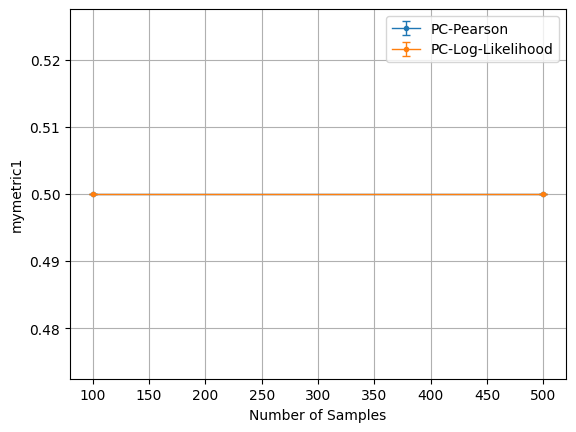

In [6]:
def mymetric_fn1(graph_est, graph_gt):
    '''
    graph_est, graph_gt are of the following form: {'a': ['b', 'c'], 'b': [], 'c': []}
    where keys are children and values specify the list of parents.
    '''
    # do something
    return 0.5
def mymetric_fn2(graph_est, graph_gt):
    '''
    graph_est, graph_gt are of the following form: {'a': ['b', 'c'], 'b': [], 'c': []}
    where keys are children and values specify the list of parents.
    '''
    # do something
    return 1

custom_metric_dict = {'mymetric1': mymetric_fn1, 'mymetric2': mymetric_fn2}

b = BenchmarkDiscreteTabular(algo_dict=algo_dict, kargs_dict=kargs_dict, 
                             num_exp=10, custom_metric_dict=custom_metric_dict)
b.benchmark_sample_complexity(T_list=[100, 500], num_vars=20, graph_density=0.1,\
                           fn = lambda x:x, coef=0.1, noise_fn=np.random.randn) # default arguments in the library
plt=b.plot('mymetric1', xaxis_mode=1)
plt.show()

### Custom Algorithms

Users may specify their own algorthms in the benchmarking module. Here we show the format such an algorithm must adhere to in order for the benchmarking module to fuction properly. Users may use this as a template to specify their own algorithm.

100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:48<00:00,  4.86s/it]


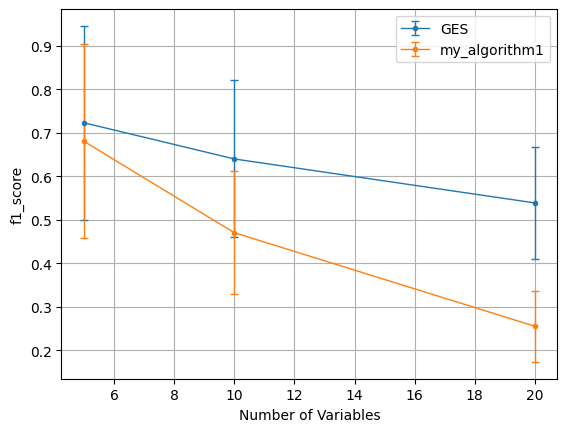

In [7]:
from causalai.data.tabular import TabularData

class myAlgorithm:
    def __init__(self, data):
        '''
        :param data: this is a TabularData object and contains attributes likes data.data_arrays, which is a 
            list of numpy array of shape (observations N, variables D).
        :type data: TabularData object 
        '''
        self.data = data
        # do something
        
    def run(self, **kargs):
        a = kargs['a']
        result = {name: {'parents': []} for name in self.data.var_names} # result must follow this format
        # do something and compute parents
        return result
    

algo_dict = {
        'GES':partial(GES, use_multiprocessing=False, prior_knowledge=None), 
        'my_algorithm1':myAlgorithm,}

kargs_dict = {
        'GES': {'phases': ['forward', 'backward', 'turning']},
        'my_algorithm1': {'a':4},}


b = BenchmarkContinuousTabular(algo_dict=algo_dict, kargs_dict=kargs_dict, 
                             num_exp=10, custom_metric_dict=custom_metric_dict)
b.benchmark_variable_complexity(num_vars_list=[5, 10, 20], graph_density=0.2, T=5000,\
                           fn = lambda x:x, coef=0.1, noise_fn=np.random.randn)
plt=b.plot('f1_score', xaxis_mode=1)
plt.show()

my_algorithm1 is a dummy algorithm which always returns a graph without no edges as the estimated causal graph. As expected, comparing it with the GES algorithm in CausalAI for continuous tabular data shows GES outperforming my_algorithm1 on the variable complexity benchmark.

### Custom Data

Users may use their own data to benchmark causal discovery algorithms instead of using synthetic data generated in our benchmarking module. For this, we support the bechmark_custom_dataset method. This method takes as input a list of datasets, where each item in the list is a triplet-- (data_array, var_names, graph_gt), where data_array is a 2D Numpy data array of shape (samples x variables), var_names is a list of variable names, and graph_gt is the ground truth causal graph in the form of a Python dictionary, where keys are the variable names, and the corresponding values are a list of parent names.

To illustrate how it works, we manually generate a list of synthetic datasets below, and call the bechmark_custom_dataset method.

In [8]:
from causalai.data.data_generator import DataGenerator, GenerateSparseTabularSEM

fn = lambda x:x
coef = 0.1
T = 5000

data_list = []
for i in range(5):
    var_names = [str(j) for j in range(np.random.randint(4,8))]
    sem = GenerateSparseTabularSEM(var_names=var_names, graph_density=0.5, seed=1)
    data_array, var_names, graph_gt = DataGenerator(sem, T=T, seed=i, discrete=False,
                                                    noise_fn=[np.random.rand]*(len(var_names)))
    data_list.append((data_array, var_names, graph_gt))



In [9]:
# use default algorithms
b = BenchmarkContinuousTabular(algo_dict=None, kargs_dict=None, custom_metric_dict=None)
b.bechmark_custom_dataset(data_list)

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  6.56it/s]


No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


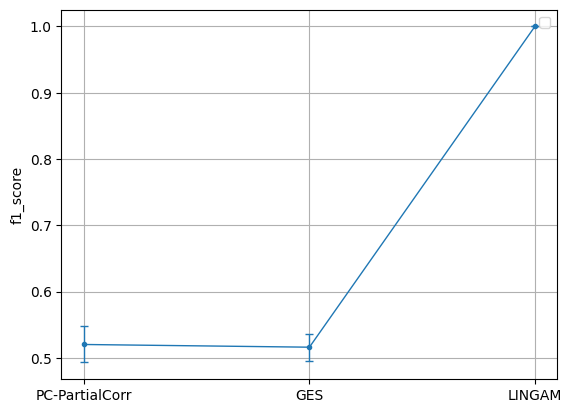

In [10]:
plt = b.plot('f1_score', xaxis_mode=0)
plt.show()